In [1]:
import yfinance as yf

import os
os.chdir('C:\\Users\\btindol\\OneDrive - Stryker\\Linked In Learn\\Algorithmic Investing\Algorithmic Trading & Quantitative Analysis using Python')  
print(os.getcwd())  # Prints the current working directory

#####################################################################################################################################################
#imports 
#!pip install yfinance 
#!pip install pandas 
#!pip install numpy
#!pip install requests
!pip install datetime
#!pip install yahoofinancials
!pip install stocktrends
from yahoofinancials import YahooFinancials

import pandas as pd
import numpy as np
import requests
import datetime as dt
import os
import json 
from functools import reduce
import statsmodels.api as sm
from stocktrends import Renko


import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\btindol\OneDrive - Stryker\Linked In Learn\Algorithmic Investing\Algorithmic Trading & Quantitative Analysis using Python


You should consider upgrading via the 'c:\users\btindol\anaconda3\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\users\btindol\anaconda3\python.exe -m pip install --upgrade pip' command.


# SINGLE STOCK ANALYZER NOW MAKE STRATEGY OFF OF IT

# CONSOLIDATION FOR EASE!!!!!!!!!!!!!!


In [2]:
# for each of the column names for the % change columns 

def shifted_column(df):
    pctchg = [col for col in df.columns if 'percent_change' in col] # grabe % change columns
    colnew = []                                                                    # initiate empty list
    for i in range(0,len(pctchg)):                                                 # loop over column names
        print(pctchg[i])
        var1 = df[pctchg[i]].shift(-1)                                            # grab colunmn by name and shift up one
        colnew.append(var1)                                                        # append to list
    colnew = pd.DataFrame(colnew)                                                  # now its wide dataframe
    colnew = colnew.transpose()                                                    # make it narrow
    cols = colnew.columns.tolist()                                                 # take column names of narrow dataframe                                                
    newcols = []                                                                   # make list to add the text shift to the column name
    for j in range(0,len(cols)): 
        colz = cols[j] + "_" + "shift"                                             # add shift to the name of shifted column

        newcols.append(colz) 
    colnew.columns = newcols  
    return colnew
    #########################################################################################
    #########################################################################################
    
def clean_up_zeros_and_column_names(df):
    df =df.fillna(0)     
    df.columns = df.columns.str.replace("-", "_") 
    return df

In [3]:
def get_daily_returns(df):
    daily_return = df.pct_change()
    cols = daily_return.columns.tolist()
    newcols = []
    for j in range(0,len(cols)):
        if cols[j] == "formatted_date":
            colz = cols[j]
        else:
            colz = cols[j] + "_" + "percent_change"

        newcols.append(colz)
    daily_return.columns = newcols               
    return daily_return

In [4]:
def get_current_position(df,initial_position):
    
    # Calculate returns from initial position entry 
    shiftval = [col for col in df.columns if 'shift' in col]                   # find the shift column to bring % change up to today to mutliply to get positions next day amount.. 

    initial_position = initial_position                                             # pass from function above

    new = [(df[shiftval[0]][0] * initial_position) + initial_position]        # get first value in final for iterate the 0 of this 
    for i in range(1, len(df.index)):                                          # starting at second row of the dataframe column 
        new.append((new[i-1]*df[shiftval].values[i][0]) +new[i-1])
    
    df['Position'] = new
    df['Position'] = df['Position'].shift(1)
    df['Position'][0] = initial_position
    df.fillna(0)
    return df#['Position']

In [5]:
# Calculating RSI without using loop
def rsi(df, n):
    "function to calculate RSI"
    delta = df["Adj Close"].diff().dropna()
    u = delta * 0
    d = u.copy()
    u[delta > 0] = delta[delta > 0]
    d[delta < 0] = -delta[delta < 0]
    u[u.index[n-1]] = np.mean( u[:n]) # first value is average of gains
    u = u.drop(u.index[:(n-1)])
    d[d.index[n-1]] = np.mean( d[:n]) # first value is average of losses
    d = d.drop(d.index[:(n-1)])
    rs = u.ewm(com=n,min_periods=n).mean()/d.ewm(com=n,min_periods=n).mean()
    return 100 - 100 / (1+rs)

In [6]:
def ATR(DF,n):
    "function to calculate True Range and Average True Range"
    df = DF.copy()
    df['H-L']=abs(df['High']-df['Low'])
    df['H-PC']=abs(df['High']-df['Adj Close'].shift(1))
    df['L-PC']=abs(df['Low']-df['Adj Close'].shift(1))
    df['TR']=df[['H-L','H-PC','L-PC']].max(axis=1,skipna=False)
    df['ATR'] = df['TR'].rolling(n).mean()
    #df['ATR'] = df['TR'].ewm(span=n,adjust=False,min_periods=n).mean()
    df2 = df.drop(['H-L','H-PC','L-PC'],axis=1)
    df2.dropna(inplace=True)
    return df2

In [7]:
def ADX(DF,n):
    "function to calculate ADX"
    df2 = DF.copy()
    df2['TR'] = ATR(df2,n)['TR'] #the period parameter of ATR function does not matter because period does not influence TR calculation
    df2['DMplus']=np.where((df2['High']-df2['High'].shift(1))>(df2['Low'].shift(1)-df2['Low']),df2['High']-df2['High'].shift(1),0)
    df2['DMplus']=np.where(df2['DMplus']<0,0,df2['DMplus'])
    df2['DMminus']=np.where((df2['Low'].shift(1)-df2['Low'])>(df2['High']-df2['High'].shift(1)),df2['Low'].shift(1)-df2['Low'],0)
    df2['DMminus']=np.where(df2['DMminus']<0,0,df2['DMminus'])
    TRn = []
    DMplusN = []
    DMminusN = []
    TR = df2['TR'].tolist()
    DMplus = df2['DMplus'].tolist()
    DMminus = df2['DMminus'].tolist()
    for i in range(len(df2)):
        if i < n:
            TRn.append(np.NaN)
            DMplusN.append(np.NaN)
            DMminusN.append(np.NaN)
        elif i == n:
            TRn.append(df2['TR'].rolling(n).sum().tolist()[n])
            DMplusN.append(df2['DMplus'].rolling(n).sum().tolist()[n])
            DMminusN.append(df2['DMminus'].rolling(n).sum().tolist()[n])
        elif i > n:
            TRn.append(TRn[i-1] - (TRn[i-1]/n) + TR[i])
            DMplusN.append(DMplusN[i-1] - (DMplusN[i-1]/n) + DMplus[i])
            DMminusN.append(DMminusN[i-1] - (DMminusN[i-1]/n) + DMminus[i])
    df2['TRn'] = np.array(TRn)
    df2['DMplusN'] = np.array(DMplusN)
    df2['DMminusN'] = np.array(DMminusN)
    df2['DIplusN']=100*(df2['DMplusN']/df2['TRn'])
    df2['DIminusN']=100*(df2['DMminusN']/df2['TRn'])
    df2['DIdiff']=abs(df2['DIplusN']-df2['DIminusN'])
    df2['DIsum']=df2['DIplusN']+df2['DIminusN']
    df2['DX']=100*(df2['DIdiff']/df2['DIsum'])
    ADX = []
    DX = df2['DX'].tolist()
    for j in range(len(df2)):
        if j < 2*n-1:
            ADX.append(np.NaN)
        elif j == 2*n-1:
            ADX.append(df2['DX'][j-n+1:j+1].mean())
        elif j > 2*n-1:
            ADX.append(((n-1)*ADX[j-1] + DX[j])/n)
    df2['ADX']=np.array(ADX)
    return df2['ADX']

In [8]:
def slope(ser,n):
    "function to calculate the slope of regression line for n consecutive points on a plot"
    ser = (ser - ser.min())/(ser.max() - ser.min())
    x = np.array(range(len(ser)))
    x = (x - x.min())/(x.max() - x.min())
    slopes = [i*0 for i in range(n-1)]
    for i in range(n,len(ser)+1):
        y_scaled = ser[i-n:i]
        x_scaled = x[:n]
        x_scaled = sm.add_constant(x_scaled)
        model = sm.OLS(y_scaled,x_scaled)
        results = model.fit()
        slopes.append(results.params[-1])
    slope_angle = (np.rad2deg(np.arctan(np.array(slopes))))
    return np.array(slope_angle)



# Come back for Renko Later!!


In [9]:
def OBV(DF):
    """function to calculate On Balance Volume"""
    df = DF.copy()
    df['daily_ret'] = df['Adj Close'].pct_change()
    df['direction'] = np.where(df['daily_ret']>=0,1,-1)
    df['direction'][0] = 0
    df['vol_adj'] = df['Volume'] * df['direction']
    df['obv'] = df['vol_adj'].cumsum()
    return df['obv']


In [10]:
def single_stock_analyzer(stocks, begin_date,end_date,initial_position,slow_ma,fast_ma):

    # looping over tickers and creating a dataframe with closing prices
    # get just adjusted close column for that ticker
    for ticker in stocks:
        AdjclosePrice = yf.download(ticker,beg_date,end_date)[['Adj Close','Open','High','Low','Close','Volume']]     
    
    # Make it a dataframe
    AdjclosePrice = pd.DataFrame(AdjclosePrice)
    
    # pass dataframe into function that gets the adjusted close percent change column
    AdjclosePrice_PctChg = get_daily_returns(AdjclosePrice)
    
    # merge percent change column to normal price of the stock (Adj Close)
    final = AdjclosePrice.merge(AdjclosePrice_PctChg, on='Date', how='left')
    
    # Shift the percent change column up for multiplying by the initial position input column later to simulate earnings.. 
    colnew =shifted_column(AdjclosePrice_PctChg)

    # join the new column onto existing Adj Close and Adj Close percent change columns 
    final_f= final.merge(colnew, on='Date', how='left')

    # fill na's with 0's and change weird characters such as - to _ in column names 
    final_f = clean_up_zeros_and_column_names(final_f)

    # See how the money you put in performed.. 
    var = get_current_position(final_f,initial_position)
    final_f['Position'] = var
    
    # Get the moving averages for the crossover strategt slow and fast moving averages..  
    final_f['Fast_moving_average'] = final_f['Adj Close'].rolling(window=fast_ma).mean() # 5 day price moving average
    final_f['Slow_moving_average'] = final_f['Adj Close'].rolling(window=slow_ma).mean() # 5 day price moving average

    # Bolligner band of the fast moving average 30 day.. 
    final_f["BB_up"] = final_f["Fast_moving_average"] + 2*final_f['Adj Close'].rolling(fast_ma).std(ddof=0) #ddof=0 is required since we want to take the standard deviation of the population and not sample
    final_f["BB_dn"] = final_f["Fast_moving_average"] - 2*final_f['Adj Close'].rolling(fast_ma).std(ddof=0) #ddof=0 is required since we want to take the standard deviation of the population and not sample
    final_f["BB_width"] = final_f["BB_up"] - final_f["BB_dn"]
    
    # rsi standard 14 periods
    final_f["RSI_fast_14_periods"] = rsi(final_f,14) # standard periods is 14
    final_f["RSI_slow_30_periods"] = rsi(final_f,30) # longer than average periods 30 
    
    # Average true range 14 period is standard 
    final_f2 = ATR(final_f,14) # 14 is standard for longer use 20 
    
    # Average directional movement here we will use a period matching the fast moving average
    final_f2['ADX'] = ADX(final_f2,fast_ma)
    
    
    #MACD, short for moving average convergence/divergence    
    """function to calculate MACD
       typical values a = 12; b =26, c =9"""
    a = 12;b=26;c=9
    final_f2["MA_Fast"]=final_f2["Adj Close"].ewm(span=a,min_periods=a).mean()
    final_f2["MA_Slow"]=final_f2["Adj Close"].ewm(span=b,min_periods=b).mean()
    final_f2["MACD"]=final_f2["MA_Fast"]-final_f2["MA_Slow"]
    final_f2["Signal"]=final_f2["MACD"].ewm(span=c,min_periods=c).mean()
    
    
    # Slope for last 5 days change if needed
    final_f2["close_slope"] = slope(final_f2["Adj Close"],5)
    
    # OBV
    OBV2= OBV(final_f2)
    
    # Merge OBV 
    final_f3 = final_f2.merge(OBV2, on='Date', how='left')
    
    return final_f3

In [11]:
stocks = ['ETH-USD']
end_date = (dt.date.today()).strftime('%Y-%m-%d')
beg_date = (dt.date.today()-dt.timedelta(1825)).strftime('%Y-%m-%d') # 1825 is 5 years ish 
final_f = single_stock_analyzer(stocks,beg_date,end_date,10.239700,30,90)
final_f

[*********************100%***********************]  1 of 1 completed
Adj Close_percent_change
Open_percent_change
High_percent_change
Low_percent_change
Close_percent_change
Volume_percent_change


,Adj Close,Open,High,Low,Close,Volume,Adj Close_percent_change,Open_percent_change,High_percent_change,Low_percent_change,...,RSI_slow_30_periods,TR,ATR,ADX,MA_Fast,MA_Slow,MACD,Signal,close_slope,obv
Date,,,,,,,,,,,,,,,,,,,,,
2016-08-16,11.139700,11.228700,11.237300,11.002800,11.139700,7051510,-0.007015,0.002410,-0.006498,0.000245,...,47.999315,0.234500,0.628923,NaN,NaN,NaN,NaN,NaN,0.000000,0
2016-08-17,10.752800,11.133200,11.154800,10.748600,10.752800,8833760,-0.034732,-0.008505,-0.007342,-0.023103,...,46.692546,0.406200,0.541457,NaN,NaN,NaN,NaN,NaN,0.000000,-8833760
2016-08-18,10.756100,10.747500,11.009100,10.744800,10.756100,6935800,0.000307,-0.034644,-0.013062,-0.000354,...,46.705333,0.264300,0.479279,NaN,NaN,NaN,NaN,NaN,0.000000,-1897960
2016-08-19,10.748700,10.746300,10.801100,10.727900,10.748700,5390850,-0.000688,-0.000112,-0.018893,-0.001573,...,46.679387,0.073200,0.454993,NaN,NaN,NaN,NaN,NaN,0.000000,-7288810
2016-08-20,11.247400,10.750100,11.300700,10.749100,11.247400,7443540,0.046396,0.000354,0.046255,0.001976,...,48.665437,0.552000,0.447864,NaN,NaN,NaN,NaN,NaN,0.503815,154730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-14,4079.057373,3720.122314,4171.017090,3703.399902,4079.057373,48174271215,0.097953,-0.028414,0.034334,0.043385,...,70.065693,467.617188,362.423689,NaN,3674.215936,3248.668433,425.547503,391.720443,-83.149822,1615620463636
2021-05-15,3638.122070,4075.951660,4129.185547,3638.122070,3638.122070,42422321751,-0.108097,0.095650,-0.010029,-0.017626,...,62.290184,491.063477,383.533046,NaN,3668.663034,3277.516851,391.146183,391.605591,-88.207786,1573198141885
2021-05-16,3587.506104,3641.830811,3878.895996,3350.951660,3587.506104,47359478734,-0.013913,-0.106508,-0.060615,-0.078934,...,61.480871,527.944336,412.360090,NaN,3656.177352,3300.479018,355.698335,384.424140,-87.096122,1525838663151


# LEFT OFF HERE !!! TRYING TO IMPLEMENT STRATEGY!!

# Get crossover strategy here then get multiple crossovers.. 

In [12]:
def sma_strategy(df,short_window,long_window):
    short_window= 30
    long_window = 90
    final_f = df.copy()

    CrossOver_Strat = final_f[["Adj Close"]]

    # Short and long moving average.. 
    CrossOver_Strat["short_mavg"] = CrossOver_Strat["Adj Close"].rolling(window= short_window,min_periods=1, center=False).mean()
    CrossOver_Strat["long_mavg"] = CrossOver_Strat["Adj Close"].rolling(window= long_window,min_periods=1, center=False).mean()

    CrossOver_Strat["signal"]=0
    CrossOver_Strat["signal"][short_window:] =np.where(CrossOver_Strat['short_mavg'][short_window:] > CrossOver_Strat['long_mavg'][short_window:],1,0)

    CrossOver_Strat["positions"] = CrossOver_Strat["signal"].diff()
    CrossOver_Strat["positions"] = CrossOver_Strat["positions"].fillna(0)

    CrossOver_Strat['buy_only'] = np.where(CrossOver_Strat['positions'] == 1,1000,0) # buy every day if 1
    CrossOver_Strat['buy_sell'] = np.where(CrossOver_Strat['positions'] == 1,1000,np.where(CrossOver_Strat['positions']==-1,-1000,0)) # buy right when it crosses over.. 

    CrossOver_Strat['percent_change_shift'] = CrossOver_Strat["Adj Close"].pct_change().shift(-1) # get percent change for adj close and shift it up for multiplication.
    CrossOver_Strat["percent_change_shift"] = CrossOver_Strat["percent_change_shift"].fillna(0)
    return CrossOver_Strat

var = sma_strategy(final_f,30,90)
var

,Adj Close,short_mavg,long_mavg,signal,positions,buy_only,buy_sell,percent_change_shift
Date,,,,,,,,
2016-08-16,11.139700,11.139700,11.139700,0,0.0,0,0,-0.034732
2016-08-17,10.752800,10.946250,10.946250,0,0.0,0,0,0.000307
2016-08-18,10.756100,10.882867,10.882867,0,0.0,0,0,-0.000688
2016-08-19,10.748700,10.849325,10.849325,0,0.0,0,0,0.046396
2016-08-20,11.247400,10.928940,10.928940,0,0.0,0,0,-0.006064
...,...,...,...,...,...,...,...,...
2021-05-14,4079.057373,2992.548763,2212.557697,1,0.0,0,0,-0.108097
2021-05-15,3638.122070,3029.848958,2232.924786,1,0.0,0,0,-0.013913
2021-05-16,3587.506104,3068.367611,2253.010509,1,0.0,0,0,-0.085047


In [13]:
def buy_at_beginning_and_hold(CrossOver_Strat,initial_position):
    initial_position = initial_position
    new = [(CrossOver_Strat.percent_change_shift.values[0] * initial_position) + initial_position] # make the first value of new column hold it in variable where we take initial position and multiply by the shifted percent change column to get initial starting value
    for i in range(1, len(CrossOver_Strat.index)): # starting at second row of the dataframe column 
        new.append((new[i-1]*CrossOver_Strat.percent_change_shift.values[i]) +new[i-1]) # take new and multiply the first calculated value by the next percent change plus the origional value to get new position value

    # Assign the list new to the dataframe column
    CrossOver_Strat['Buy_at_Begining_and_Hold_Position'] = new
    CrossOver_Strat['Buy_at_Begining_and_Hold_Position'] = CrossOver_Strat['Buy_at_Begining_and_Hold_Position'].round(2).shift(1) # shift it down to make since since shifted percent change up one value
    CrossOver_Strat.Buy_at_Begining_and_Hold_Position.iloc[0] = initial_position  # inject the initial starting amount into the first value of the column.. 
    return CrossOver_Strat

var2 = buy_at_beginning_and_hold(var,11.218400)
var2

,Adj Close,short_mavg,long_mavg,signal,positions,buy_only,buy_sell,percent_change_shift,Buy_at_Begining_and_Hold_Position
Date,,,,,,,,,
2016-08-16,11.139700,11.139700,11.139700,0,0.0,0,0,-0.034732,11.2184
2016-08-17,10.752800,10.946250,10.946250,0,0.0,0,0,0.000307,10.8300
2016-08-18,10.756100,10.882867,10.882867,0,0.0,0,0,-0.000688,10.8300
2016-08-19,10.748700,10.849325,10.849325,0,0.0,0,0,0.046396,10.8200
2016-08-20,11.247400,10.928940,10.928940,0,0.0,0,0,-0.006064,11.3300
...,...,...,...,...,...,...,...,...,...
2021-05-14,4079.057373,2992.548763,2212.557697,1,0.0,0,0,-0.108097,4107.8800
2021-05-15,3638.122070,3029.848958,2232.924786,1,0.0,0,0,-0.013913,3663.8200
2021-05-16,3587.506104,3068.367611,2253.010509,1,0.0,0,0,-0.085047,3612.8500


In [14]:
import random

In [15]:
def get_random_list_of_indexes(df):
    additional = df[df['positions'] == 1.0].sum().positions # get the sum of positions and minus the first for the entry amount.. 
    additional= (additional-1).astype(int) # minus 1 becuase when comparing when you initialize at first cross over you dont add additional to first 

    #additional_amount = 1000
     # Make random list of certain amount of variables as many as there are buys
    randomlist = []
    for i in range(0,additional):
        n = random.randint(1,1732)
        randomlist.append(n)
    randomlist.sort()
    return randomlist

randomlist = get_random_list_of_indexes(var2)
randomlist

[469, 767, 784, 818, 1031, 1235, 1615, 1651]

In [18]:
def additional_amount_column(df,randomlist,additional_amount,initial_amount):
    for i in range(0,len(randomlist)):
        newindex = randomlist[i]
        df.loc[df.index[newindex], 'additional_contribution'] = additional_amount

    df['additional_contribution'][0] = initial_amount
    df['additional_contribution']  =var2['additional_contribution'].fillna(0)  
    df.additional_contribution.count()
    return df

varf = additional_amount_column(var2,randomlist,1000,100)
varf

,Adj Close,short_mavg,long_mavg,signal,positions,buy_only,buy_sell,percent_change_shift,Buy_at_Begining_and_Hold_Position,additional_contribution
Date,,,,,,,,,,
2016-08-16,11.139700,11.139700,11.139700,0,0.0,0,0,-0.034732,11.2184,100.0
2016-08-17,10.752800,10.946250,10.946250,0,0.0,0,0,0.000307,10.8300,0.0
2016-08-18,10.756100,10.882867,10.882867,0,0.0,0,0,-0.000688,10.8300,0.0
2016-08-19,10.748700,10.849325,10.849325,0,0.0,0,0,0.046396,10.8200,0.0
2016-08-20,11.247400,10.928940,10.928940,0,0.0,0,0,-0.006064,11.3300,0.0
...,...,...,...,...,...,...,...,...,...,...
2021-05-14,4079.057373,2992.548763,2212.557697,1,0.0,0,0,-0.108097,4107.8800,0.0
2021-05-15,3638.122070,3029.848958,2232.924786,1,0.0,0,0,-0.013913,3663.8200,0.0
2021-05-16,3587.506104,3068.367611,2253.010509,1,0.0,0,0,-0.085047,3612.8500,0.0


In [19]:
varf[varf['additional_contribution'] > 0].count().additional_contribution # This works.. 

9

In [20]:

# Mkke colunmn that gets the value of current position for the additional contribution strategy.. 
def buy_beginning_randomly_contribute_same_number_of_times_as_strategy(df):
    initial_position = df['additional_contribution'][0]
    new = [(df.percent_change_shift.values[0] * initial_position) + initial_position]
    for i in range(1, len(df.index)): # starting at second row of the dataframe column 
         new.append((new[i-1]*df.percent_change_shift.values[i]) + new[i-1] +df.additional_contribution.values[i])# take new and multiply the first calculated value by the next percent change plus the origional value to get new position value
    df['buy_at_begin_and_random_contribute'] = new
    return df
dff =buy_beginning_randomly_contribute_same_number_of_times_as_strategy(varf)
dff

,Adj Close,short_mavg,long_mavg,signal,positions,buy_only,buy_sell,percent_change_shift,Buy_at_Begining_and_Hold_Position,additional_contribution,buy_at_begin_and_random_contribute
Date,,,,,,,,,,,
2016-08-16,11.139700,11.139700,11.139700,0,0.0,0,0,-0.034732,11.2184,100.0,96.526837
2016-08-17,10.752800,10.946250,10.946250,0,0.0,0,0,0.000307,10.8300,0.0,96.556458
2016-08-18,10.756100,10.882867,10.882867,0,0.0,0,0,-0.000688,10.8300,0.0,96.490033
2016-08-19,10.748700,10.849325,10.849325,0,0.0,0,0,0.046396,10.8200,0.0,100.966816
2016-08-20,11.247400,10.928940,10.928940,0,0.0,0,0,-0.006064,11.3300,0.0,100.354590
...,...,...,...,...,...,...,...,...,...,...,...
2021-05-14,4079.057373,2992.548763,2212.557697,1,0.0,0,0,-0.108097,4107.8800,0.0,135909.214034
2021-05-15,3638.122070,3029.848958,2232.924786,1,0.0,0,0,-0.013913,3663.8200,0.0,134018.354922
2021-05-16,3587.506104,3068.367611,2253.010509,1,0.0,0,0,-0.085047,3612.8500,0.0,122620.429887


In [21]:

def counter_column(df):
    newft = []
    counter = 0
    for i in range(0, len(df.index)):
        if df.signal.values[i] == 0 and counter == 0:
            newft.append(0)
        else:
            counter +=1
            newft.append(counter)
    return  newft  

dff['counter'] =counter_column(dff)
dff

,Adj Close,short_mavg,long_mavg,signal,positions,buy_only,buy_sell,percent_change_shift,Buy_at_Begining_and_Hold_Position,additional_contribution,buy_at_begin_and_random_contribute,counter
Date,,,,,,,,,,,,
2016-08-16,11.139700,11.139700,11.139700,0,0.0,0,0,-0.034732,11.2184,100.0,96.526837,0
2016-08-17,10.752800,10.946250,10.946250,0,0.0,0,0,0.000307,10.8300,0.0,96.556458,0
2016-08-18,10.756100,10.882867,10.882867,0,0.0,0,0,-0.000688,10.8300,0.0,96.490033,0
2016-08-19,10.748700,10.849325,10.849325,0,0.0,0,0,0.046396,10.8200,0.0,100.966816,0
2016-08-20,11.247400,10.928940,10.928940,0,0.0,0,0,-0.006064,11.3300,0.0,100.354590,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-14,4079.057373,2992.548763,2212.557697,1,0.0,0,0,-0.108097,4107.8800,0.0,135909.214034,1699
2021-05-15,3638.122070,3029.848958,2232.924786,1,0.0,0,0,-0.013913,3663.8200,0.0,134018.354922,1700
2021-05-16,3587.506104,3068.367611,2253.010509,1,0.0,0,0,-0.085047,3612.8500,0.0,122620.429887,1701


In [22]:
# MAKE COLUMN WHERE YOU ARE TAKING THE INITAL POSITION AT FIRST CROSSOVER THEN YOU ARE ADDING 1000 DOLLARS TO EACH BUY SIGNAL AFTER.. 
# MAKE SURE THAT THE BUY SIGNAL IS THE SAME NUMBER OF BUYS AS THE RANDOMLY SPACED SCENARIO SO ITS EVEN.. 

initial_position = 100
varzf = dff[dff.positions == 1].first_valid_index()    # find first strategy entry position
dff["Position_Start"] = np.where(dff.index == varzf,initial_position,0) # find first time that position is activated.. 
dff["buy_only_final"] = np.where(dff.index == varzf,0,dff["buy_only"])  # we will only buy not sell
dff["inital_position_at_first_crossover_buy_only"] = np.where(dff.index == varzf,initial_position,dff["buy_only_final"])
dff.head(50)
#dff.to_csv("comz.csv")

filtered_df = dff.loc[varzf::,]  # bottom half after first signal.. 

# Top half with no calculation.. 
length = len(dff.loc[:varzf,])-1
filtered_df2 = dff.iloc[:length,] 

initial_position = 100
new = [(filtered_df.percent_change_shift.values[0] * initial_position) + initial_position]
for i in range(1, len(filtered_df.index)): # starting at second row of the dataframe column 
     new.append((new[i-1]*filtered_df.percent_change_shift.values[i]) + new[i-1] +filtered_df.inital_position_at_first_crossover_buy_only.values[i])# take new and multiply the first calculated value by the next percent change plus the origional value to get new position value
filtered_df['crossover_buy_only_final'] = new
filtered_df['crossover_buy_only_final'].replace(np.nan, 0)
filtered_df.head(50)


final_df = pd.concat([filtered_df2, filtered_df])
#final_df.to_csv("comzz.csv")
final_df

,Adj Close,short_mavg,long_mavg,signal,positions,buy_only,buy_sell,percent_change_shift,Buy_at_Begining_and_Hold_Position,additional_contribution,buy_at_begin_and_random_contribute,counter,Position_Start,buy_only_final,inital_position_at_first_crossover_buy_only,crossover_buy_only_final
Date,,,,,,,,,,,,,,,,
2016-08-16,11.139700,11.139700,11.139700,0,0.0,0,0,-0.034732,11.2184,100.0,96.526837,0,0,0,0,NaN
2016-08-17,10.752800,10.946250,10.946250,0,0.0,0,0,0.000307,10.8300,0.0,96.556458,0,0,0,0,NaN
2016-08-18,10.756100,10.882867,10.882867,0,0.0,0,0,-0.000688,10.8300,0.0,96.490033,0,0,0,0,NaN
2016-08-19,10.748700,10.849325,10.849325,0,0.0,0,0,0.046396,10.8200,0.0,100.966816,0,0,0,0,NaN
2016-08-20,11.247400,10.928940,10.928940,0,0.0,0,0,-0.006064,11.3300,0.0,100.354590,0,0,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-14,4079.057373,2992.548763,2212.557697,1,0.0,0,0,-0.108097,4107.8800,0.0,135909.214034,1699,0,0,0,464633.132635
2021-05-15,3638.122070,3029.848958,2232.924786,1,0.0,0,0,-0.013913,3663.8200,0.0,134018.354922,1700,0,0,0,458168.848381
2021-05-16,3587.506104,3068.367611,2253.010509,1,0.0,0,0,-0.085047,3612.8500,0.0,122620.429887,1701,0,0,0,419202.736684


# NOW MAKE COLUMN WHERE YOU BUY 1000 WHEN 1 AND sell all of your stock or a certain percentage at -1..
# Then rebuy all you have again when hits 1.. 



for i in range(0,len(df)):
    when turns first singal buy.
    if turns 1 then add 1000 $ 
    if turns -1 then exit all of trade and sell all stock
    if turns 1 again then buy with all of money you have again. 
    
    

In [72]:
filtered_df.iloc[i][0]

3442.565185546875

In [35]:
returnz

[112.55580043792725,
 113.83591780753785,
 111.4388267329282,
 118.23208515564323,
 129.35964918789375,
 123.42698364127052,
 118.757396983748,
 119.50772276419656,
 115.44324581590253,
 117.44231354023594,
 114.95199385049298,
 117.41900852374319,
 119.00123619152725,
 117.19578989548724,
 118.55301216008982,
 118.08596287321694,
 118.32800675690835,
 120.59332104346983,
 119.02095910900661,
 116.85783295969304,
 115.23167969589294,
 113.5535389760061,
 109.53746738478542,
 108.05475196644215,
 105.3815485962836,
 105.65227491956898,
 106.97722409640188,
 107.24167533454211,
 107.01935436833008,
 107.42455046579539,
 107.13947864813186,
 107.6181804432511,
 112.84893411566144,
 107.77595523392378,
 108.46083717678906,
 109.14571911965433,
 108.21431353204035,
 107.89607951372554,
 107.29545811471665,
 102.32018760916962,
 103.37799256173054,
 103.0884409830097,
 99.3717867038307,
 93.63005814853143,
 100.24761418718224,
 98.59277848378815,
 96.51212610340546,
 -3.487873896594536,
 -3.

In [73]:
# I THINK THAT THIS IS CORRECT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
############################################################################################
############################################################################################

#balance =100# how much you have on you balance
#amount_of_cash_put_in =[]
additional_amount = 1000
cash_to_spend = [] # this is how much cash you have invested in now
returnz = [] # list of returns
amount_of_cash_put_in =[]
initial_position = 100
varzf = filtered_df[filtered_df.positions == 1].first_valid_index() 
filtered_df = filtered_df.loc[varzf::,]  # bottom half after first signal.. 
length = len(dff.loc[:varzf,])-1
filtered_df2 = dff.iloc[:length,]

for i in range(0,len(filtered_df)):
    if i == 0: # if it is the first value of dataframe where we filter to the first crossover as the first row
        returnzvar =(initial_position  * filtered_df.iloc[i][7]) + (initial_position) # multiply the price or adjusted value by the % change and add initial position plus price.. (NOt sure if i should do this??? no multiply for first posotiion??)
        returnz.append(returnzvar)
        
        cash_to_spend.append(0)
        amount_of_cash_put_in.append(initial_position) # append to cashposition list the initial entry position as first value 

       
    elif filtered_df.positions[i] == 0:
    # Basically then we take the previous value times tjhe return plus previous value
        returnzvar = (returnz[i-1] * filtered_df.iloc[i][7]) + returnz[i-1] # take last returnz value then multiply it 
        returnz.append(returnzvar)
        
        cash_to_spend.append(cash_to_spend[i-1])
        amount_of_cash_put_in.append(amount_of_cash_put_in[i-1])
        
    elif filtered_df.positions[i] == -1:
        #returnval = #(returnz[i-1] * -1)# hold for later with cash append 0 because we sold all 
        returnz.append(0)

        cash_to_spend.append(returnz[i-1]) # append the last value of the growing number that you multiply by return.. 
        amount_of_cash_put_in.append(0)

    elif filtered_df.positions[i] == 1: # if its not the first time the cross over happnes (aka) when we put initial position down
        returnz.append(cash_to_spend[i-1] + additional_amount) # because from -1 to 1 cash to spend has been the last value of returnsz we grab that value
   
        cash_to_spend.append(0) # Make cash to spend 0 again because we are buying agiain which means take all cash on hand and put it back into the stock. 
        amount_of_cash_put_in.append(1000)
        
    


    else:
        continue
        

In [74]:
cash_to_spend

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010130344,
 90.19100010

In [75]:
returnz

[105.18388329589581,
 106.3801585254823,
 104.14006652790975,
 110.48839596409707,
 120.88715277611338,
 115.34305111221258,
 110.97930214402153,
 111.68048483756141,
 107.8822135150276,
 109.75035096684056,
 107.4231364243981,
 109.72857232793038,
 111.20717094042497,
 109.51997355245554,
 110.78830364056395,
 110.3518440579149,
 110.5780351161778,
 112.69498113423408,
 111.22560209228328,
 109.20415133134115,
 107.68450405900782,
 106.11627428366175,
 102.36323797708883,
 100.97763399295607,
 98.47951385859642,
 98.7325087809619,
 99.97067952868663,
 100.21781035678941,
 100.01005045038484,
 100.38870795947739,
 100.12230711044602,
 100.56965601255015,
 105.4578179881012,
 100.7170972381874,
 101.35712238188967,
 101.99714752559193,
 101.12674496750464,
 100.82935389824856,
 100.2680705979427,
 95.61865874902094,
 96.60718206143208,
 96.33659485627858,
 92.86336532540292,
 87.49769510736408,
 93.68182990419638,
 92.13537876776047,
 90.19100010130344,
 0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,

In [77]:
# Make the returnz column a column in the dataset now as well as cash to spend... 
filtered_df['buy_sell_crossover_strat_returnz'] = returnz
filtered_df['buy_sell_crossover_strat_cash'] = cash_to_spend
filtered_df.to_csv("crossover_strat2.csv")

In [67]:
filtered_df

,Adj Close,short_mavg,long_mavg,signal,positions,buy_only,buy_sell,percent_change_shift,Buy_at_Begining_and_Hold_Position,additional_contribution,buy_at_begin_and_random_contribute,counter,Position_Start,buy_only_final,inital_position_at_first_crossover_buy_only,crossover_buy_only_final,buy_sell_crossover_strat_returnz,buy_sell_crossover_strat_cash
Date,,,,,,,,,,,,,,,,,,
2016-09-15,11.937000,11.448860,11.438887,1,1.0,1000,1000,0.051839,12.02,0.0,112.712196,1,100,0,100,105.183883,112.555800,0.0
2016-09-16,12.555800,11.508960,11.473791,1,0.0,0,0,0.011373,12.64,0.0,113.994092,2,0,0,0,106.380159,113.835918,0.0
2016-09-17,12.698600,11.573710,11.510906,1,0.0,0,0,-0.021057,12.79,0.0,111.593670,3,0,0,0,104.140067,111.438827,0.0
2016-09-18,12.431200,11.629793,11.537974,1,0.0,0,0,0.060960,12.52,0.0,118.396368,4,0,0,0,110.488396,118.232085,0.0
2016-09-19,13.189000,11.694513,11.585146,1,0.0,0,0,0.094116,13.28,0.0,129.539394,5,0,0,0,120.887153,129.359649,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-14,4079.057373,2992.548763,2212.557697,1,0.0,0,0,-0.108097,4107.88,0.0,135909.214034,1699,0,0,0,464633.132635,739584.658703,0.0
2021-05-15,3638.122070,3029.848958,2232.924786,1,0.0,0,0,-0.013913,3663.82,0.0,134018.354922,1700,0,0,0,458168.848381,729295.066489,0.0
2021-05-16,3587.506104,3068.367611,2253.010509,1,0.0,0,0,-0.085047,3612.85,0.0,122620.429887,1701,0,0,0,419202.736684,667270.349790,0.0


In [78]:
final_df = pd.concat([filtered_df2, filtered_df])
#final_df.to_csv("comzz.csv")
final_df

,Adj Close,short_mavg,long_mavg,signal,positions,buy_only,buy_sell,percent_change_shift,Buy_at_Begining_and_Hold_Position,additional_contribution,buy_at_begin_and_random_contribute,counter,Position_Start,buy_only_final,inital_position_at_first_crossover_buy_only,crossover_buy_only_final,buy_sell_crossover_strat_returnz,buy_sell_crossover_strat_cash
Date,,,,,,,,,,,,,,,,,,
2016-08-16,11.139700,11.139700,11.139700,0,0.0,0,0,-0.034732,11.2184,100.0,96.526837,0,0,0,0,NaN,NaN,NaN
2016-08-17,10.752800,10.946250,10.946250,0,0.0,0,0,0.000307,10.8300,0.0,96.556458,0,0,0,0,NaN,NaN,NaN
2016-08-18,10.756100,10.882867,10.882867,0,0.0,0,0,-0.000688,10.8300,0.0,96.490033,0,0,0,0,NaN,NaN,NaN
2016-08-19,10.748700,10.849325,10.849325,0,0.0,0,0,0.046396,10.8200,0.0,100.966816,0,0,0,0,NaN,NaN,NaN
2016-08-20,11.247400,10.928940,10.928940,0,0.0,0,0,-0.006064,11.3300,0.0,100.354590,0,0,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-14,4079.057373,2992.548763,2212.557697,1,0.0,0,0,-0.108097,4107.8800,0.0,135909.214034,1699,0,0,0,464633.132635,736073.380218,0.0
2021-05-15,3638.122070,3029.848958,2232.924786,1,0.0,0,0,-0.013913,3663.8200,0.0,134018.354922,1700,0,0,0,458168.848381,725832.639238,0.0
2021-05-16,3587.506104,3068.367611,2253.010509,1,0.0,0,0,-0.085047,3612.8500,0.0,122620.429887,1701,0,0,0,419202.736684,664102.393295,0.0


# Look at the strategy visually.. Not that great lets optimize by adding multiple crossovers.. and picking the best one.
Make function that takes two numbers and makes moving average crossover test.. to find best one 

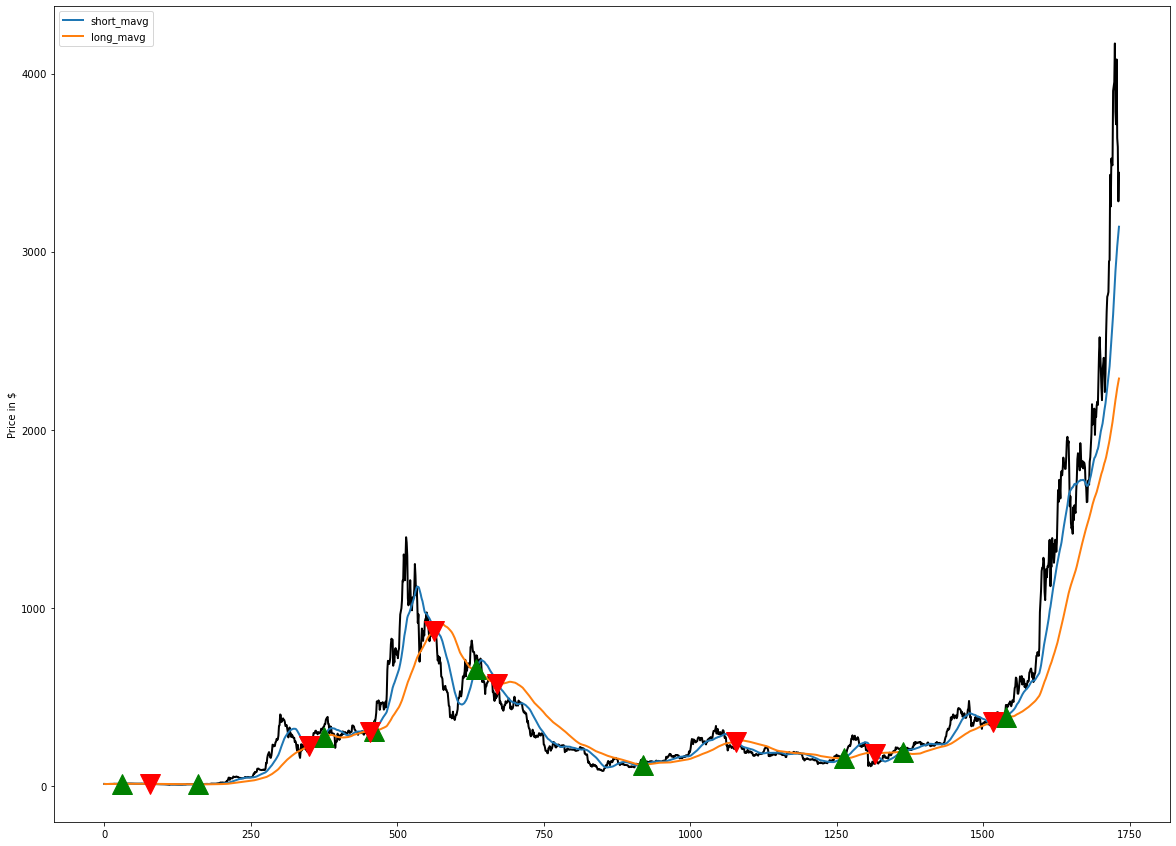

In [79]:
final_df.reset_index(inplace=True)

# Visualize the strategy
fig = plt.figure(figsize = (20,15))

# subplot added 
axl = fig.add_subplot(111,ylabel = 'Price in $')

# Plot the closing price
final_df['Adj Close'].plot(ax = axl,color = 'black',lw=2.)

# Plot the short and long movijng averages
final_df[['short_mavg','long_mavg']].plot(ax=axl,lw=2.)

#plot the buy signals
axl.plot(final_df.loc[final_df.positions == 1.0].index,
        final_df.short_mavg[final_df.positions==1.0],
        '^',markersize=20,color='g')

axl.plot(final_df.loc[final_df.positions == -1.0].index,
        final_df.short_mavg[final_df.positions== -1.0],
        'v',markersize=20,color='r')

plt.show()

In [80]:
# TO DO
##############
# Make function that makes the moving average crossover easy just put in symbol, date range, additional amount to invest, initial amount , long and short moving average..
# take that function and find most profitiable combination for moving average..
# then do advanced filtering as such:
    # if singal goes off at perfect crossover.. get the: (last 5 day slope, atr,last 5 day average mcad or mcad kertosis, renko trend,rsi,obv,volume, etc.. and see what drawdown in 1 week is and 2 weeks)
    # how likely if you get 1 vs 4 vs 8 long moving averages cross over price that it will result in a certain percent drop in a certain time frame.. 
    # moving average slopes etc.. 